In [1]:
%matplotlib widget

In [2]:
import flammkuchen as fl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json
import imageio
from scipy.stats import sem
import seaborn as sns
from bouter.free import FreelySwimmingExperiment
import pandas as pd
from scipy import signal
from tqdm import tqdm
from scipy.stats import zscore
from scipy.interpolate import interp1d
from sklearn.neighbors import KernelDensity as kde
from scipy.stats import linregress
from scipy.spatial.distance import euclidean
from scipy.signal import medfilt
from scipy.signal import savgol_filter
from scipy.stats import mannwhitneyu, ttest_1samp
import random

In [3]:
def sidak(α,m):
    return α*(α / (1-(1-0.05)**(1/m)))
def clip(x_):
    x_[x_>200]=200
    x_[x_<0]= 0
    return x_
def clean_augment(x_,stim_fun,setpoint):
    out_ = []
    for df_ in x_:
        if "flip_x_start" in df_.keys():
            pass
        else:
            df_["flip_x_start"] = df_["al_start_x"]
            df_["flip_y_start"] = df_["al_start_y"]
            
            df_["flip_x_end"] = df_["al_end_x"]
            df_["flip_y_end"] = df_["al_end_y"]
        df_["flip_x_start"] = clip(df_["flip_x_start"].values)
        try:
            df_["flip_x_end"] = clip(df_["flip_x_end"].values)
        except:
            df_["flip_x_end"] = clip(df_["al_end_x"].values)
        out_.append(augment(df_,stim_fun,setpoint))
    return out_

def clean_augment_cpca(x_,stim_fun,setpoint):
    out_ = []
    for df_ in x_:
        df_["flip_x_start"] = abs(200-clip(df_["flip_x_start"].values))
        out_.append(augment(df_,stim_fun,setpoint))
    return out_

def dist_setpoint(values,setpoint):
    return abs(values - setpoint)

def augment(bout_properties,fun,setpoint,time_th=2):
    border_x = [10, 190]
    border_y = [5, 45]
    x_start = []
    x_end = []
    temp_start = []
    temp_end = []
    temp_pre = []
    delta = []
    delta_prev = []
    out = []
    prev_biases = []
    temporal_distance = []
    prev_bout = None
    prev_bias = None
    prev_temp = None
    delta_prev_prev_bout = None
    delta_prev_bout = np.nan
    for i in range(len(bout_properties)):
        
        bout = bout_properties.iloc[i]
        if prev_bout is not None:
            temporal_distance = bout["t_start"] - prev_bout["t_end"] 
            if (temporal_distance <= time_th)& (delta_prev_bout!=np.nan):
                delta_prev_prev_bout = delta_prev_bout
            else:
                delta_prev_prev_bout  = np.nan
                
        if prev_bout is not None:
            temporal_distance = bout["t_start"] - prev_bout["t_end"] 
            if temporal_distance <= time_th:
                prev_bias = prev_bout["theta_bout"]
                
                delta_prev_bout = dist_setpoint(float(fun(prev_bout["flip_x_start"])),setpoint) - dist_setpoint(float(fun(bout["flip_x_start"])),setpoint)
                prev_temp = dist_setpoint(float(fun(prev_bout["flip_x_start"])),setpoint)
            else:
                delta_prev_bout  = np.nan
                prev_bias = np.nan
                prev_temp = np.nan
            
        temp_start.append(dist_setpoint(float(fun(bout["flip_x_start"])),setpoint))
        delta.append(delta_prev_bout)
        delta_prev.append(delta_prev_prev_bout)
        x_start.append(bout['flip_x_start'])
        temp_pre.append(prev_temp)
        prev_biases.append(prev_bias)
        if (border_x[0] <= bout["flip_x_start"] <= border_x[1]) and (border_y[0] <= bout["y_start"] <= border_y[1]):
            is_out = False
        else:
            is_out = True
        out.append(is_out)
        prev_bout = bout.copy()
    bout_properties["temp_start"] = temp_start
    bout_properties["delta"]=delta
    bout_properties["delta_1"]=delta_prev
    bout_properties["out"]=out
    bout_properties["prev_bias"]=prev_biases
    bout_properties["prev_temp"] = temp_pre
    return bout_properties

def prefered_temperature(x_position,times,resolution=2):
    result = medfilt(np.interp(np.linspace(0,15*60,15*60*resolution),
            times,x_position),3)
    return np.nanmedian(result[600*resolution:])

def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh) 

In [4]:
plt.rcParams.update({'font.size': 25})

In [5]:
setpoint_wt = 25.280104571722397
setpoint_hb = 27.89187878451635
setpoint_abl = 27.181914005550055

In [7]:
full_dataset = fl.load(r"U:\experiments\virtual_gradients_experiments\freely_swim_Ruben\data.h5")

transfer_fun = interp1d(full_dataset["stimulus_calibration"][0,:],
                             full_dataset["stimulus_calibration"][1,:],
                             kind="quadratic")
WT = clean_augment(full_dataset["WT"].copy(),transfer_fun,setpoint_wt)
Hbpos_pre = clean_augment(full_dataset["Hbpos_pre_ablation"].copy(),transfer_fun,setpoint_hb)
Hbneg_post = clean_augment(full_dataset["Hbneg_post_ablation"].copy(),transfer_fun,setpoint_hb)
Hbpos_post = clean_augment(full_dataset["Hbpos_ablation"].copy(),transfer_fun,setpoint_hb)

In [41]:
twopabl_dataset = fl.load(r"Z:\experiments\virtual_gradients_experiments\data_2p_ablations.h5")
poa_abl = clean_augment(twopabl_dataset["poa"].copy(),transfer_fun,setpoint_abl)
ot_abl = clean_augment(twopabl_dataset["ot"].copy(),transfer_fun,setpoint_abl)

In [534]:
bins_theta = np.arange(0,np.deg2rad(100),np.deg2rad(20))
hists = []
for fish_ in WT:
    bouts_in_bin = abs(fish_.iloc[(fish_["delta"].values>=0.1333)]["theta_bout"])
    c,_ = np.histogram(bouts_in_bin,bins_theta)
    c = c / np.sum(c)
    
    bouts_in_bin = abs(fish_.iloc[(fish_["delta"].values<=-0.1333)]["theta_bout"])
    c0,_ = np.histogram(bouts_in_bin,bins_theta)
    c0 = c0 / np.sum(c0)
    
    hists.append(np.array([c,c0]))
hists = np.stack(hists)

C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [65]:
full_dataset.keys()

dict_keys(['Hbneg_post_ablation', 'Hbpos_ablation', 'Hbpos_pre_ablation', 'WT', 'fluoxetine', 'no_stim', 'stimulus_calibration'])

In [188]:
mean_at_WT = []
mean_at_Hbpos_post = []
mean_at_Hbpos_pre = []
mean_at_Hbneg_post = []
mean_at_PoA = []
mean_at_OT = []

for cond_,res_ in zip([WT,Hbpos_post,Hbpos_pre,Hbneg_post,poa_abl,ot_abl], 
                     [mean_at_WT,
                    mean_at_Hbpos_post,
                    mean_at_Hbpos_pre,
                    mean_at_Hbneg_post,
                    mean_at_PoA,
                    mean_at_OT]):
    for fish_ in cond_:
        mat = np.nanmax(abs(fish_["theta_bout"].values))
        res_.append(mat)

C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  


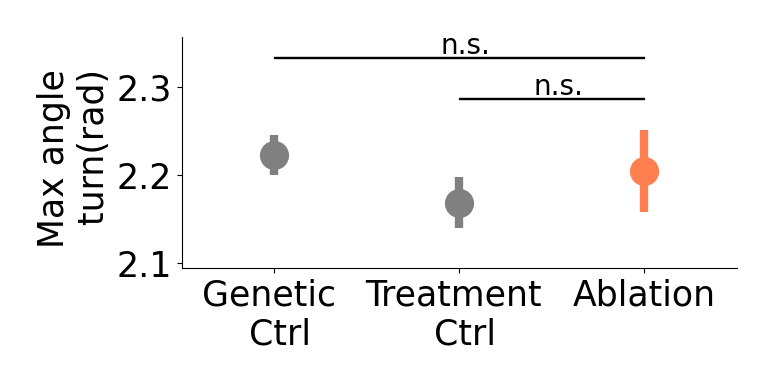

In [130]:
plt.figure()
plt.errorbar([0,1],
            [
            np.nanmean(mean_at_Hbpos_pre),np.nanmean(mean_at_Hbneg_post)],
            yerr=[
            sem(mean_at_Hbpos_pre),sem(mean_at_Hbneg_post)], 
            lw=6,fmt="o",ms=14,marker="o",mew=7,c="gray",
            capthick=5)

plt.errorbar([2],
            [
            np.nanmean(mean_at_Hbpos_post)],
            yerr=[
            sem(mean_at_Hbpos_post)], 
            lw=6,fmt="o",ms=14,marker="o",mew=7,c="coral",
            capthick=5)
plt.xlim(-.5,2.5)
plt.ylim([np.deg2rad(120),np.deg2rad(135)])
plt.xticks([0,1,2],["Genetic \n Ctrl",
           "Treatment \n Ctrl",
           "Ablation"], fontsize=25)
plt.ylabel("Max angle \n turn(rad)", fontsize=25)
plt.yticks([2.1,2.2,2.3])

plt.axvspan(0,2,.91,.915,color="k")
plt.text(0.9,2.337,"n.s.",color="k",fontsize=20)

plt.axvspan(1,2,.73,.735,color="k")
plt.text(1.4,2.29,"n.s.",color="k",fontsize=20)

set_size(6,3)
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\new_figs_new\figures_reviews\rev2_point3_0_Hb.png",dpi=800)

In [89]:
print(mannwhitneyu(mean_at_Hbpos_pre, mean_at_Hbpos_post),
      mannwhitneyu(mean_at_Hbneg_post, mean_at_Hbpos_post))

MannwhitneyuResult(statistic=176.0, pvalue=0.9883205831071411) MannwhitneyuResult(statistic=123.0, pvalue=0.24024987870349757)


C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  


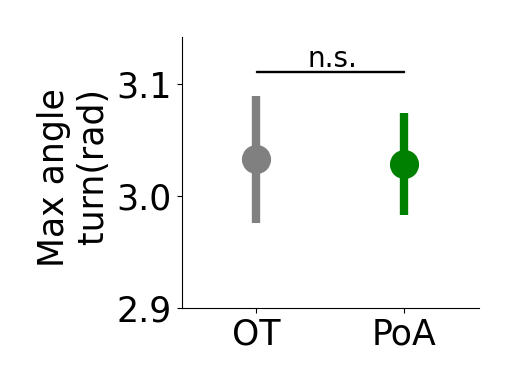

In [189]:
plt.figure()
plt.errorbar([0],
            [
            np.nanmean(mean_at_OT)],
            yerr=[
            sem(mean_at_OT)], 
            lw=6,fmt="o",ms=14,marker="o",mew=7,c="gray",
            capthick=5)

plt.errorbar([1],
            [
            np.nanmean(mean_at_PoA)],
            yerr=[
            sem(mean_at_PoA)], 
            lw=6,fmt="o",ms=14,marker="o",mew=7,c="green",
            capthick=5)
plt.xlim(-.5,1.5)
plt.ylim([np.deg2rad(170),np.deg2rad(180)])
plt.xticks([0,1],["OT",
           "PoA"], fontsize=25)
plt.ylabel("Max angle \n turn(rad)", fontsize=25)
plt.yticks([2.9,3,3.1])

plt.axvspan(0,1,.87,.875,color="k")
plt.text(0.35,3.115,"n.s.",color="k",fontsize=20)



set_size(4,3)
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\new_figs_new\figures_reviews\rev2_point3_1_poa.png",dpi=800)

In [154]:
mannwhitneyu(mean_at_PoA, mean_at_OT)

MannwhitneyuResult(statistic=207.5, pvalue=0.8498110603586766)

In [190]:
mean_at_WT = []
mean_at_Hbpos_post = []
mean_at_Hbpos_pre = []
mean_at_Hbneg_post = []
mean_at_PoA = []
mean_at_OT = []

for cond_,res_ in zip([WT,Hbpos_post,Hbpos_pre,Hbneg_post,poa_abl,ot_abl], 
                     [mean_at_WT,
                    mean_at_Hbpos_post,
                    mean_at_Hbpos_pre,
                    mean_at_Hbneg_post,
                    mean_at_PoA,
                    mean_at_OT]):
    for fish_ in cond_:
        res_.append(fish_["theta_bout"].values.shape[0]/900)

In [191]:
print(mannwhitneyu(mean_at_Hbpos_pre, mean_at_Hbpos_post),
      mannwhitneyu(mean_at_Hbneg_post, mean_at_Hbpos_post))

MannwhitneyuResult(statistic=224.0, pvalue=0.15562671993768185) MannwhitneyuResult(statistic=136.0, pvalue=0.4429328101581169)


C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  


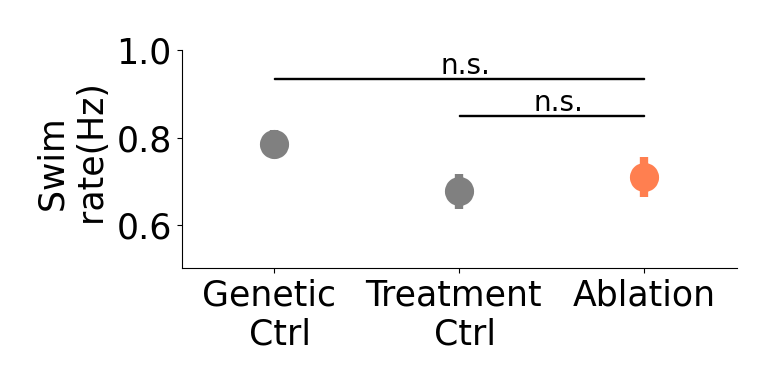

In [175]:
plt.figure()
plt.errorbar([0,1],
            [
            np.nanmean(mean_at_Hbpos_pre),np.nanmean(mean_at_Hbneg_post)],
            yerr=[
            sem(mean_at_Hbpos_pre),sem(mean_at_Hbneg_post)], 
            lw=6,fmt="o",ms=14,marker="o",mew=7,c="gray",
            capthick=5)

plt.errorbar([2],
            [
            np.nanmean(mean_at_Hbpos_post)],
            yerr=[
            sem(mean_at_Hbpos_post)], 
            lw=6,fmt="o",ms=14,marker="o",mew=7,c="coral",
            capthick=5)
plt.xlim(-.5,2.5)
plt.ylim([0.5,1])
plt.xticks([0,1,2],["Genetic \n Ctrl",
           "Treatment \n Ctrl",
           "Ablation"], fontsize=25)
plt.ylabel("Swim \n rate(Hz)", fontsize=25)
# plt.yticks([2.1,2.2,2.3])

plt.axvspan(0,2,.87,.875,color="k")
plt.text(0.9,0.945,"n.s.",color="k",fontsize=20)

plt.axvspan(1,2,.70,.705,color="k")
plt.text(1.4,0.86,"n.s.",color="k",fontsize=20)

set_size(6,3)
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\new_figs_new\figures_reviews\rev2_point3_2_Hb.png",dpi=800)

C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:16: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  


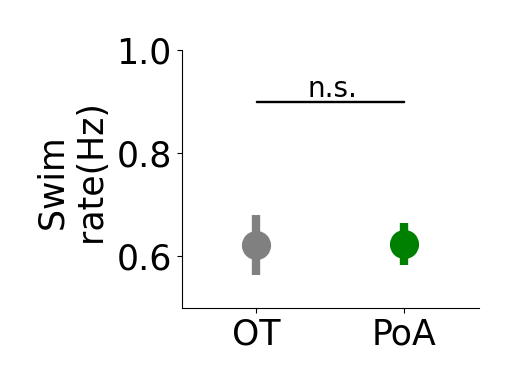

In [187]:
plt.figure()
plt.errorbar([0],
            [
            np.nanmean(mean_at_OT)],
            yerr=[
            sem(mean_at_OT)], 
            lw=6,fmt="o",ms=14,marker="o",mew=7,c="gray",
            capthick=5)

plt.errorbar([1],
            [
            np.nanmean(mean_at_PoA)],
            yerr=[
            sem(mean_at_PoA)], 
            lw=6,fmt="o",ms=14,marker="o",mew=7,c="green",
            capthick=5)
plt.xlim(-.5,1.5)
plt.ylim([.5,1])
plt.xticks([0,1],["OT",
           "PoA"], fontsize=25)
plt.ylabel("Swim \n rate(Hz)", fontsize=25)
# plt.yticks([2.9,3,3.1])

plt.axvspan(0,1,.80,.805,color="k")
plt.text(0.35,0.91,"n.s.",color="k",fontsize=20)



set_size(4,3)
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\new_figs_new\figures_reviews\rev2_point3_3_poa.png",dpi=800)

In [535]:
colors = ["#8e530b","#036860"]

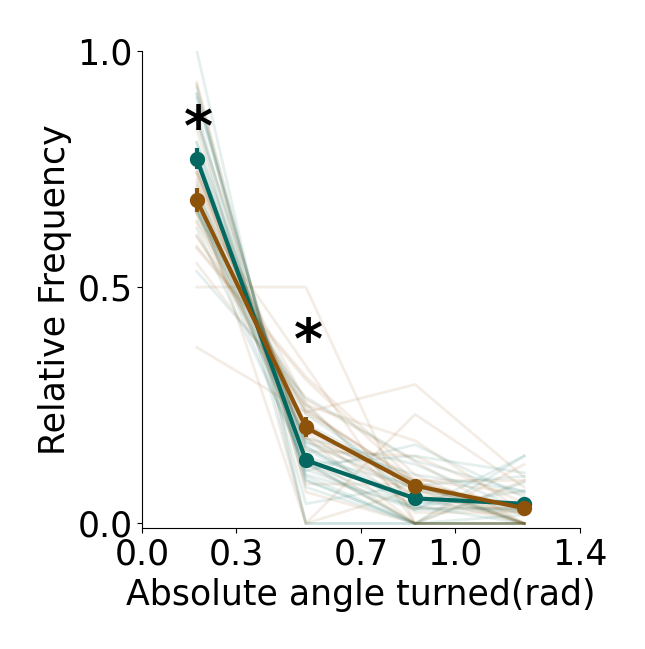

In [537]:
bins_center = (bins_theta[1:]+bins_theta[:-1])/2
plt.figure()

plt.plot(bins_center,hists[:,0,:].T,lw=2,color=colors[-1],alpha=.1)

plt.plot(bins_center,hists[:,1,:].T,lw=2,color=colors[0],alpha=.1)

plt.errorbar(bins_center,np.nanmean(hists[:,0,:],0),
             yerr=sem(hists[:,0,:],0,nan_policy="omit"),
            lw=3,fmt="-",ms=6,marker="o",mew=5,c=colors[1],
            capthick=5)

plt.errorbar(bins_center,np.nanmean(hists[:,1,:],0),
             yerr=sem(hists[:,-1,:],0,nan_policy="omit"),
            lw=3,fmt="-",ms=6,marker="o",mew=5,c=colors[0],
            capthick=5)

plt.text(bins_center[0]-.04,0.8,"*",color="k",fontsize=40,fontweight="bold")
plt.text(bins_center[1]-.04,0.35,"*",color="k",fontsize=40,fontweight="bold")

plt.ylabel("Relative Frequency",fontsize=25)
plt.xlabel("Absolute angle turned(rad)",fontsize=25)
plt.yticks([0,.5,1],fontsize=25)
plt.ylim([-.01,1])
plt.xlim(bins_theta[0],bins_theta[-1])
plt.xticks(np.round(bins_theta,1),fontsize=25)
set_size(5,5)
sns.despine()
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs_new\2_a_I.png",dpi=800)

In [12]:
for i in range(hists.shape[-1]):
    print(mannwhitneyu(hists[:,0,i],hists[:,1,i])[1]*4)

0.04869218781101344
0.014639933714851165
0.4736594072038014
1.083882530013311


In [708]:
bins_theta = np.arange(-np.deg2rad(0),np.deg2rad(180),np.deg2rad(5))
pool_WT = pd.concat(WT)
bouts_in_bin = abs(pool_WT.iloc[(pool_WT["delta"].values>=0.1333)]["theta_bout"])
c,_ = np.histogram(bouts_in_bin,bins_theta)
c = c / np.sum(c)

bouts_in_bin = abs(pool_WT.iloc[(pool_WT["delta"].values<=-0.1333)]["theta_bout"])
c0,_ = np.histogram(bouts_in_bin,bins_theta)
c0 = c0 / np.sum(c0)
bins_center = (bins_theta[1:]+bins_theta[:-1])/2


C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater_equal
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less_equal
  import sys


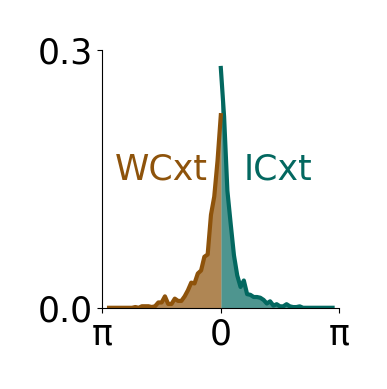

In [710]:
plt.figure()
plt.fill_between(bins_center-bins_center[0],y1=np.zeros(c.shape[0]),y2=c,color=colors[1],alpha=.7,lw=0)
plt.fill_between(-bins_center+bins_center[0],y1=np.zeros(c.shape[0]),y2=c0,color=colors[0],alpha=.7,lw=0)
plt.plot(bins_center-bins_center[0],c,colors[1],alpha=1,lw=3)
plt.plot(-bins_center+bins_center[0],c0,colors[0],alpha=1,lw=3)
# plt.plot([0,0],[0,np.nanmax(c)],lw=2,color="gray")
plt.text(0.6,.15,"ICxt",fontsize=25,color=colors[-1])
plt.text(-2.8,.15,"WCxt",fontsize=25,color=colors[0])

plt.ylim([0,.3])
plt.yticks([0,.3],fontsize=25)
plt.xlim([-np.pi,np.pi])
plt.xticks([-np.pi,0,np.pi],["π","0","π"],fontsize=25)
sns.despine()
set_size(3,3)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\2_a_II.png",dpi=800)

In [711]:
turn_th = np.deg2rad(30)
th_min_bouts = 5
iso_th = 0.1333
delta_bins = np.array([-3,-iso_th,iso_th,3])
turn_index = []
for fish_ in WT:
    fish_vect = []
    for s_,e_ in zip(delta_bins[:-1],delta_bins[1:]):
        bouts_in_bin = fish_.iloc[(fish_["delta"].values>=s_)&(fish_["delta"].values<e_)&(fish_["temp_start"].values>1)]
        if len(bouts_in_bin) > th_min_bouts:
            fract_turns = [(abs(bouts_in_bin["theta_bout"].values)>turn_th).sum()/len(bouts_in_bin)]
        else:
            fract_turns = [np.nan]
        fish_vect.append(fract_turns)
    turn_index.append(fish_vect-np.array(fish_vect[-1]))
turn_index = np.array(turn_index)
print(mannwhitneyu(turn_index[:,0,0],turn_index[:,-1,0])[1])

C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


0.04790165547348931


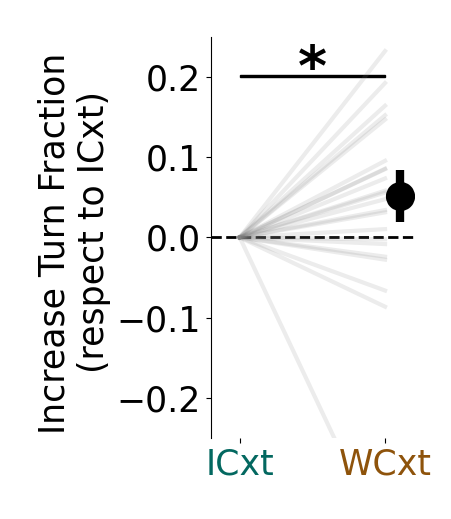

In [712]:
bins_center = np.array([1.1])
plt.figure()
plt.plot([-.2,1.2],[0,0],"--",color="k",lw=2)
plt.plot(np.stack([np.zeros(turn_index.shape[0]),turn_index[:,0,0]]),c="gray",alpha=.15,lw=3)
plt.errorbar(bins_center,np.nanmedian(turn_index[:,0,0],0),
             yerr=sem(turn_index[:,0,0],0,nan_policy="omit")*1.23,
            lw=6,fmt="-",ms=14,marker="o",mew=7,c="k",
            capthick=5)

plt.axvspan(0,1,.9,.905,color="k")
plt.text(.4,0.19,"*",color="k",fontsize=40,fontweight="bold")

plt.ylabel("Increase Turn Fraction \n (respect to ICxt)",fontsize=25)
plt.xticks([0,1],["ICxt","WCxt"],fontsize=25)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), ["#036860","#8e530b"]):
    ticklabel.set_color(tickcolor)
plt.ylim([-.25,.25])
plt.yticks([-.2,-.1,0,.1,.2],fontsize=25)
plt.xlim([-.2,1.2])
sns.despine(bottom=True)
set_size(3.5,4)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\2_b.png",dpi=800)

In [43]:
turn_index_hbneg_post = []
for fish_ in Hbneg_post:
    fish_vect = []
    for s_,e_ in zip(delta_bins[:-1],delta_bins[1:]):
        bouts_in_bin = fish_.iloc[(fish_["delta"].values>=s_)&(fish_["delta"].values<e_)&(fish_["temp_start"].values>1)]
        if len(bouts_in_bin) > th_min_bouts:
            fract_turns = [(abs(bouts_in_bin["theta_bout"].values)>turn_th).sum()/len(bouts_in_bin)]
        else:
            fract_turns = [np.nan]
        fish_vect.append(fract_turns)
    turn_index_hbneg_post.append(fish_vect-np.array(fish_vect[-1]))
turn_index_hbneg_post = np.array(turn_index_hbneg_post)
# print(mannwhitneyu(turn_index_hbneg_post[:,0,0],turn_index_hbneg_post[:,-1,0])[1])

turn_index_hbpos_pre = []
for fish_ in Hbpos_pre:
    fish_vect = []
    for s_,e_ in zip(delta_bins[:-1],delta_bins[1:]):
        bouts_in_bin = fish_.iloc[(fish_["delta"].values>=s_)&(fish_["delta"].values<e_)&(fish_["temp_start"].values>1)]
        if len(bouts_in_bin) > th_min_bouts:
            fract_turns = [(abs(bouts_in_bin["theta_bout"].values)>turn_th).sum()/len(bouts_in_bin)]
        else:
            fract_turns = [np.nan]
        fish_vect.append(fract_turns)
    turn_index_hbpos_pre.append(fish_vect-np.array(fish_vect[-1]))
turn_index_hbpos_pre = np.array(turn_index_hbpos_pre)
# print(mannwhitneyu(turn_index_hbpos_pre[:,0,0],turn_index_hbpos_pre[:,-1,0])[1])

turn_index_hbpos_post = []
for fish_ in Hbpos_post:
    fish_vect = []
    for s_,e_ in zip(delta_bins[:-1],delta_bins[1:]):
        bouts_in_bin = fish_.iloc[(fish_["delta"].values>=s_)&(fish_["delta"].values<e_)&(fish_["temp_start"].values>1)]
        if len(bouts_in_bin) > th_min_bouts:
            fract_turns = [(abs(bouts_in_bin["theta_bout"].values)>turn_th).sum()/len(bouts_in_bin)]
        else:
            fract_turns = [np.nan]
        fish_vect.append(fract_turns)
    turn_index_hbpos_post.append(fish_vect-np.array(fish_vect[-1]))
turn_index_hbpos_post = np.array(turn_index_hbpos_post)
# print(mannwhitneyu(turn_index_hbpos_post[:,0,0],turn_index_hbpos_post[:,-1,0])[1])

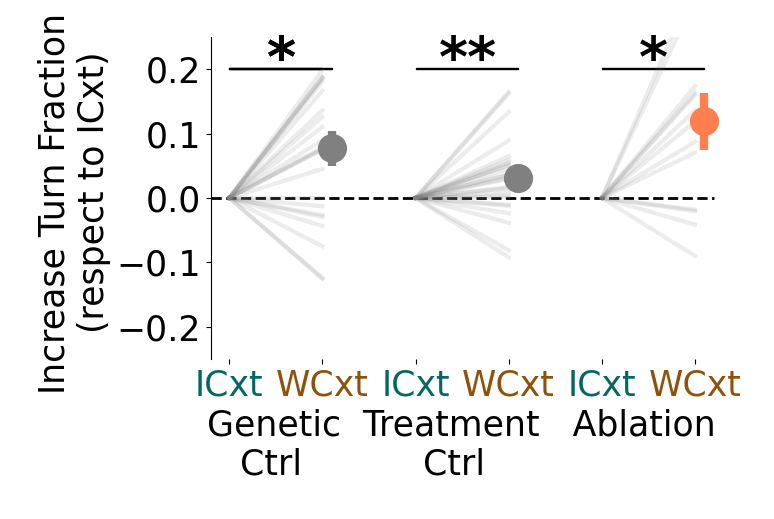

In [59]:
bins_center = np.array([1.1])
plt.figure()
plt.plot([-.2,5.2],[0,0],"--",color="k",lw=2)
plt.plot(np.stack([np.zeros(turn_index_hbneg_post.shape[0]),turn_index_hbneg_post[:,0,0]]),c="gray",alpha=.15,lw=3)
plt.errorbar(bins_center,np.nanmedian(turn_index_hbneg_post[:,0,0],0),
             yerr=sem(turn_index_hbneg_post[:,0,0],0,nan_policy="omit")*1.23,
            lw=6,fmt="-",ms=14,marker="o",mew=7,c="gray",
            capthick=5)

plt.axvspan(0,1,.9,.905,color="k")
plt.text(.4,0.19,"*",color="k",fontsize=40,fontweight="bold")

bins_center = np.array([3.1])
plt.plot([2,3],np.stack([np.zeros(turn_index_hbpos_pre.shape[0]),turn_index_hbpos_pre[:,0,0]]),c="gray",alpha=.15,lw=3)
plt.errorbar(bins_center,np.nanmedian(turn_index_hbpos_pre[:,0,0],0),
             yerr=sem(turn_index_hbpos_pre[:,0,0],0,nan_policy="omit")*1.23,
            lw=6,fmt="-",ms=14,marker="o",mew=7,c="gray",
            capthick=5)

plt.axvspan(0,1.1,.9,.905,color="k")
plt.text(.4,0.19,"*",color="k",fontsize=40,fontweight="bold")

plt.axvspan(2,3.1,.9,.905,color="k")
plt.text(2.25,0.19,"**",color="k",fontsize=40,fontweight="bold")

plt.axvspan(4,5.1,.9,.905,color="k")
plt.text(4.4,0.19,"*",color="k",fontsize=40,fontweight="bold")

bins_center = np.array([5.1])
plt.plot([4,5],np.stack([np.zeros(turn_index_hbpos_post.shape[0]),turn_index_hbpos_post[:,0,0]]),c="gray",alpha=.15,lw=3)
plt.errorbar(bins_center,np.nanmedian(turn_index_hbpos_post[:,0,0],0),
             yerr=sem(turn_index_hbpos_post[:,0,0],0,nan_policy="omit")*1.23,
            lw=6,fmt="-",ms=14,marker="o",mew=7,c="coral",
            capthick=5)

plt.ylabel("Increase Turn Fraction \n (respect to ICxt)",fontsize=25)
plt.xlabel("Genetic  Treatment   Ablation \n Ctrl           Ctrl                    ",fontsize=25)
plt.xticks([0,1,2,3,4,5],["ICxt","WCxt"]*3,fontsize=25)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), ["#036860","#8e530b"]*3):
    ticklabel.set_color(tickcolor)
plt.ylim([-.25,.25])
plt.yticks([-.2,-.1,0,.1,.2],fontsize=25)
plt.xlim([-.2,5.3])
sns.despine(bottom=True)
set_size(6,4)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\final_svgs\5_e_new.png",dpi=800)

In [705]:
turn_index_ot_abl = []
for fish_ in ot_abl:
    fish_vect = []
    for s_,e_ in zip(delta_bins[:-1],delta_bins[1:]):
        bouts_in_bin = fish_.iloc[(fish_["delta"].values>=s_)&(fish_["delta"].values<e_)&(fish_["temp_start"].values>1)]
        if len(bouts_in_bin) > th_min_bouts:
            fract_turns = [(abs(bouts_in_bin["theta_bout"].values)>turn_th).sum()/len(bouts_in_bin)]
        else:
            fract_turns = [np.nan]
        fish_vect.append(fract_turns)
    turn_index_ot_abl.append(fish_vect-np.array(fish_vect[-1]))
turn_index_ot_abl = np.array(turn_index_ot_abl)
print(mannwhitneyu(turn_index_ot_abl[:,0,0],turn_index_ot_abl[:,-1,0])[1])

turn_index_poa_abl = []
for fish_ in poa_abl:
    fish_vect = []
    for s_,e_ in zip(delta_bins[:-1],delta_bins[1:]):
        bouts_in_bin = fish_.iloc[(fish_["delta"].values>=s_)&(fish_["delta"].values<e_)&(fish_["temp_start"].values>1)]
        if len(bouts_in_bin) > th_min_bouts:
            fract_turns = [(abs(bouts_in_bin["theta_bout"].values)>turn_th).sum()/len(bouts_in_bin)]
        else:
            fract_turns = [np.nan]
        fish_vect.append(fract_turns)
    turn_index_poa_abl.append(fish_vect-np.array(fish_vect[-1]))
turn_index_poa_abl = np.array(turn_index_poa_abl)
print(mannwhitneyu(turn_index_poa_abl[:,0,0],turn_index_poa_abl[:,-1,0])[1])

C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """


0.013563376522842107


C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater_equal
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


0.10137360231813286


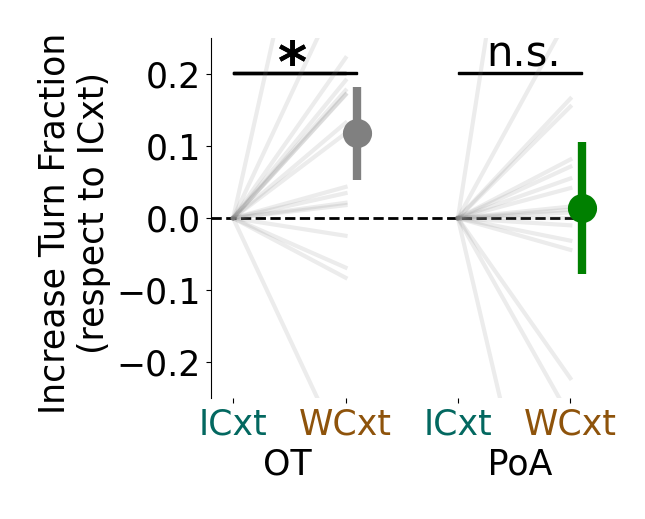

In [706]:
bins_center = np.array([1.1])
plt.figure()
plt.plot([-.2,3.2],[0,0],"--",color="k",lw=2)
plt.plot(np.stack([np.zeros(turn_index_ot_abl.shape[0]),turn_index_ot_abl[:,0,0]]),c="gray",alpha=.15,lw=3)
plt.errorbar(bins_center,np.nanmedian(turn_index_ot_abl[:,0,0],0),
             yerr=sem(turn_index_ot_abl[:,0,0],0,nan_policy="omit")*1.23,
            lw=6,fmt="-",ms=14,marker="o",mew=7,c="gray",
            capthick=5)

plt.axvspan(0,1,.9,.905,color="k")
plt.text(.4,0.19,"*",color="k",fontsize=40,fontweight="bold")

bins_center = np.array([3.1])
plt.plot([2,3],np.stack([np.zeros(turn_index_poa_abl.shape[0]),turn_index_poa_abl[:,0,0]]),c="gray",alpha=.15,lw=3)
plt.errorbar(bins_center,np.nanmedian(turn_index_poa_abl[:,0,0],0),
             yerr=sem(turn_index_poa_abl[:,0,0],0,nan_policy="omit")*1.23,
            lw=6,fmt="-",ms=14,marker="o",mew=7,c="green",
            capthick=5)

plt.axvspan(0,1.1,.9,.905,color="k")
plt.text(.4,0.19,"*",color="k",fontsize=40,fontweight="bold")

plt.axvspan(2,3.1,.9,.905,color="k")
plt.text(2.25,0.21,"n.s.",color="k",fontsize=30)

plt.ylabel("Increase Turn Fraction \n (respect to ICxt)",fontsize=25)
plt.xlabel("OT                PoA",fontsize=25)
plt.xticks([0,1,2,3],["ICxt","WCxt"]*2,fontsize=25)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), ["#036860","#8e530b"]*2):
    ticklabel.set_color(tickcolor)
plt.ylim([-.25,.25])
plt.yticks([-.2,-.1,0,.1,.2],fontsize=25)
plt.xlim([-.2,3.3])
sns.despine(bottom=True)
set_size(5,4)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\5_d.png",dpi=800)

In [694]:
turn_index = []
for fish_ in WT:
    distant = fish_["temp_start"].values >1
    fish_ = fish_.iloc[(fish_["delta"].values>-iso_th)&(fish_["delta"].values<iso_th)&distant]
    fish_vect = []
    for s_,e_ in zip(delta_bins[:-1],delta_bins[1:]):
        temp_past = fish_["prev_temp"].values-fish_["delta_1"].values
        delta_past = fish_["prev_temp"].values - temp_past
        bouts_in_bin = fish_.iloc[(delta_past>=s_)&(delta_past<e_)]
        if len(bouts_in_bin) > th_min_bouts:
            fract_turns = [(abs(bouts_in_bin["theta_bout"].values)>turn_th).sum()/len(bouts_in_bin)]
        else:
            fract_turns = [np.nan]
        fish_vect.append(fract_turns)
    turn_index.append(fish_vect-np.array(fish_vect[-1]))
turn_index = np.array(turn_index)
print(mannwhitneyu(turn_index[:,0,0],turn_index[:,-1,0])[1])

C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater_equal
  if __name__ == '__main__':
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


0.0077526431842079606


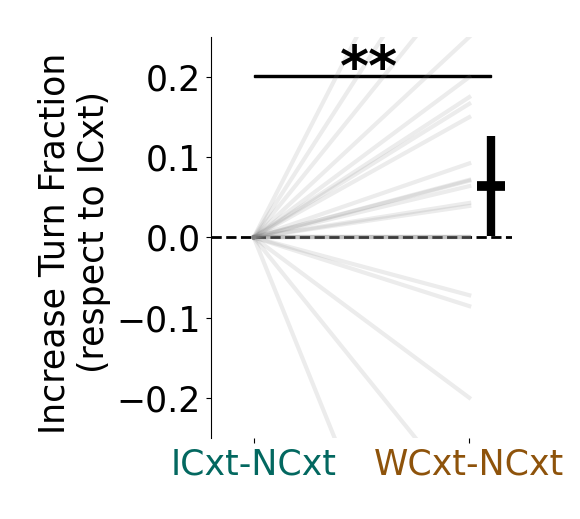

In [695]:
bins_center = np.array([1.1])
plt.figure()
plt.plot([-.2,1.2],[0,0],"--",color="k",lw=2)
plt.plot(np.stack([np.zeros(turn_index.shape[0]),turn_index[:,0,0]]),c="gray",alpha=.15,lw=3)
plt.errorbar(bins_center,np.nanmedian(turn_index[:,0,0],0),
             yerr=sem(turn_index[:,0,0],0,nan_policy="omit")*1.23,
            lw=6,fmt="-",ms=20,marker="_",mew=7,c="k",
            capthick=5)

plt.axvspan(0,1.1,.9,.905,color="k")
plt.text(.4,0.19,"**",color="k",fontsize=40,fontweight="bold")

plt.ylabel("Increase Turn Fraction \n (respect to ICxt)",fontsize=25)
plt.xticks([0,1],["ICxt-NCxt","WCxt-NCxt"],fontsize=25)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), ["#036860","#8e530b"]):
    ticklabel.set_color(tickcolor)
plt.ylim([-.25,.25])
plt.yticks([-.2,-.1,0,.1,.2],fontsize=25)
plt.xlim([-.2,1.2])
sns.despine(bottom=True)
set_size(4.5,4)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\supp_2_f.png",dpi=800)

In [78]:
turn_index_hbneg_post = []
for fish_ in Hbneg_post:
    distant = fish_["temp_start"].values >1
    fish_ = fish_.iloc[(fish_["delta"].values>-iso_th)&(fish_["delta"].values<iso_th)&distant]
    fish_vect = []
    for s_,e_ in zip(delta_bins[:-1],delta_bins[1:]):
        temp_past = fish_["prev_temp"].values-fish_["delta_1"].values
        delta_past = fish_["prev_temp"].values - temp_past
        bouts_in_bin = fish_.iloc[(delta_past>=s_)&(delta_past<e_)]
        if len(bouts_in_bin) > th_min_bouts:
            fract_turns = [(abs(bouts_in_bin["theta_bout"].values)>turn_th).sum()/len(bouts_in_bin)]
        else:
            fract_turns = [np.nan]
        fish_vect.append(fract_turns)
    turn_index_hbneg_post.append(fish_vect-np.array(fish_vect[-1]))
turn_index_hbneg_post = np.array(turn_index_hbneg_post)
# print(mannwhitneyu(turn_index_hbneg_post[:,0,0],turn_index_hbneg_post[:,-1,0])[1])

turn_index_hbpos_pre = []
for fish_ in Hbpos_pre:
    distant = fish_["temp_start"].values >1
    fish_ = fish_.iloc[(fish_["delta"].values>-iso_th)&(fish_["delta"].values<iso_th)&distant]
    fish_vect = []
    for s_,e_ in zip(delta_bins[:-1],delta_bins[1:]):
        temp_past = fish_["prev_temp"].values-fish_["delta_1"].values
        delta_past = fish_["prev_temp"].values - temp_past
        bouts_in_bin = fish_.iloc[(delta_past>=s_)&(delta_past<e_)]
        if len(bouts_in_bin) > th_min_bouts:
            fract_turns = [(abs(bouts_in_bin["theta_bout"].values)>turn_th).sum()/len(bouts_in_bin)]
        else:
            fract_turns = [np.nan]
        fish_vect.append(fract_turns)
    turn_index_hbpos_pre.append(fish_vect-np.array(fish_vect[-1]))
turn_index_hbpos_pre = np.array(turn_index_hbpos_pre)
# print(mannwhitneyu(turn_index_hbpos_pre[:,0,0],turn_index_hbpos_pre[:,-1,0])[1])

turn_index_hbpos_post = []
for fish_ in Hbpos_post:
    distant = fish_["temp_start"].values >1
    fish_ = fish_.iloc[(fish_["delta"].values>-iso_th)&(fish_["delta"].values<iso_th)&distant]
    fish_vect = []
    for s_,e_ in zip(delta_bins[:-1],delta_bins[1:]):
        temp_past = fish_["prev_temp"].values-fish_["delta_1"].values
        delta_past = fish_["prev_temp"].values - temp_past
        bouts_in_bin = fish_.iloc[(delta_past>=s_)&(delta_past<e_)]
        if len(bouts_in_bin) > th_min_bouts:
            fract_turns = [(abs(bouts_in_bin["theta_bout"].values)>turn_th).sum()/len(bouts_in_bin)]
        else:
            fract_turns = [np.nan]
        fish_vect.append(fract_turns)
    turn_index_hbpos_post.append(fish_vect-np.array(fish_vect[-1]))
turn_index_hbpos_post = np.array(turn_index_hbpos_post)
# print(mannwhitneyu(turn_index_hbpos_post[:,0,0],turn_index_hbpos_post[:,-1,0])[1])

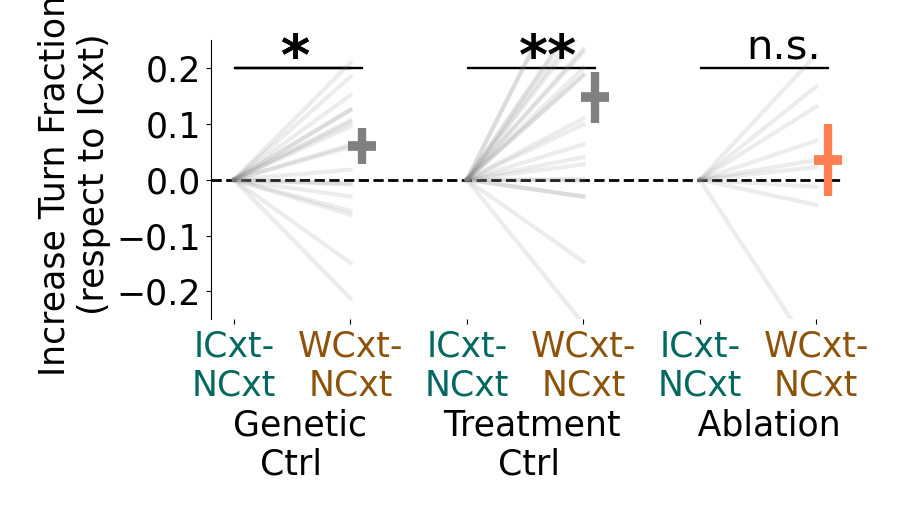

In [116]:
bins_center = np.array([1.1])
plt.figure()
plt.plot([-.2,5.2],[0,0],"--",color="k",lw=2)
plt.plot(np.stack([np.zeros(turn_index_hbneg_post.shape[0]),turn_index_hbneg_post[:,0,0]]),c="gray",alpha=.15,lw=3)
plt.errorbar(bins_center,np.nanmedian(turn_index_hbneg_post[:,0,0],0),
             yerr=sem(turn_index_hbneg_post[:,0,0],0,nan_policy="omit")*1.23,
            lw=6,fmt="-",ms=20,marker="_",mew=7,c="gray",
            capthick=5)

plt.axvspan(0,1,.9,.905,color="k")
plt.text(.4,0.19,"*",color="k",fontsize=40,fontweight="bold")

bins_center = np.array([3.1])
plt.plot([2,3],np.stack([np.zeros(turn_index_hbpos_pre.shape[0]),turn_index_hbpos_pre[:,0,0]]),c="gray",alpha=.15,lw=3)
plt.errorbar(bins_center,np.nanmedian(turn_index_hbpos_pre[:,0,0],0),
             yerr=sem(turn_index_hbpos_pre[:,0,0],0,nan_policy="omit")*1.23,
            lw=6,fmt="-",ms=20,marker="_",mew=7,c="gray",
            capthick=5)

plt.axvspan(0,1.1,.9,.905,color="k")
plt.text(.4,0.19,"*",color="k",fontsize=40,fontweight="bold")

plt.axvspan(2,3.1,.9,.905,color="k")
plt.text(2.45,0.19,"**",color="k",fontsize=40,fontweight="bold")

plt.axvspan(4,5.1,.9,.905,color="k")
plt.text(4.4,0.215,"n.s.",color="k",fontsize=30)

bins_center = np.array([5.1])
plt.plot([4,5],np.stack([np.zeros(turn_index_hbpos_post.shape[0]),turn_index_hbpos_post[:,0,0]]),c="gray",alpha=.15,lw=3)
plt.errorbar(bins_center,np.nanmedian(turn_index_hbpos_post[:,0,0],0),
             yerr=sem(turn_index_hbpos_post[:,0,0],0,nan_policy="omit")*1.23,
            lw=6,fmt="-",ms=20,marker="_",mew=7,c="coral",
            capthick=5)

plt.ylabel("Increase Turn Fraction \n (respect to ICxt)",fontsize=25)
plt.xlabel(" Genetic       Treatment       Ablation\n  Ctrl                Ctrl                        ",fontsize=25)
plt.xticks([0,1,2,3,4,5],["ICxt-\nNCxt","WCxt-\nNCxt"]*3,fontsize=25)
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), ["#036860","#8e530b"]*3):
    ticklabel.set_color(tickcolor)
plt.ylim([-.25,.25])
plt.yticks([-.2,-.1,0,.1,.2],fontsize=25)
plt.xlim([-.2,5.3])
sns.despine(bottom=True)
set_size(7,4)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\final_svgs\supp_6_f.png",dpi=800)

In [8]:
turn_th = np.deg2rad(30)
th_min_bouts = 5
iso_th = 0.1333
delta_bins = np.array([-np.inf,-iso_th,iso_th,10])
context_matrix = []
for fish_ in WT:
    distant = fish_["temp_start"].values >1
    temp_past = fish_["prev_temp"].values-fish_["delta_1"].values
    delta_past = fish_["prev_temp"].values - temp_past
    delta_ = np.digitize(fish_["delta"].values[distant],np.array([-np.inf,-iso_th,iso_th, np.inf]))-1
    delta_prev = np.digitize(delta_past[distant],np.array([-np.inf,-iso_th,iso_th, np.inf]))-1
    matrix_ = np.zeros((3,3))
    for i in range(3):
        for j in range(3):
            matrix_[i,j] = np.sum((delta_prev==i)&(delta_==j))
    
        matrix_[i,:] = matrix_[i,:] / np.sum(matrix_[i,:])
    context_matrix.append(matrix_)
context_matrix = np.stack(context_matrix)

C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


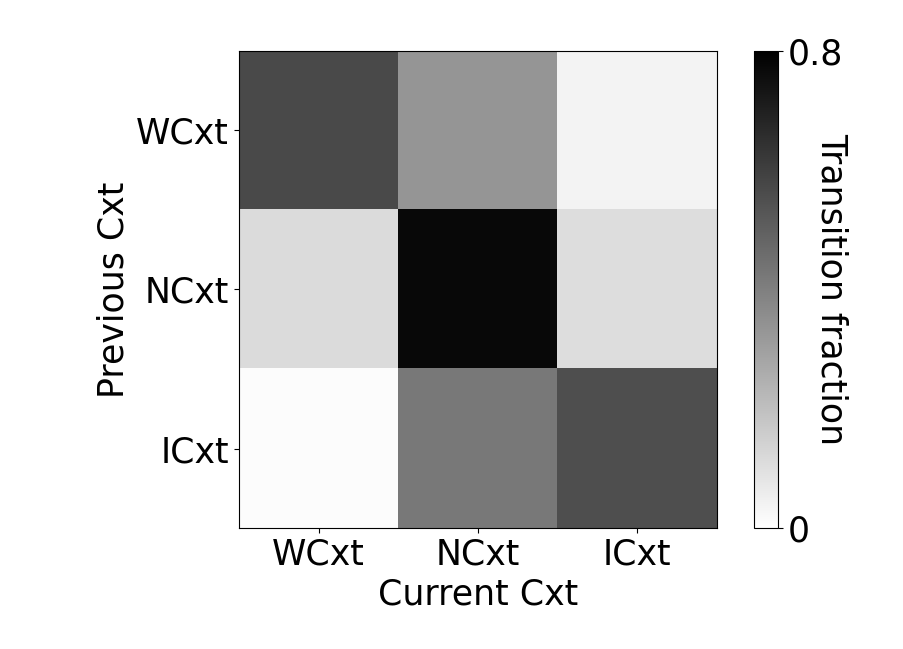

In [9]:
plt.figure()
plt.imshow(np.nanmedian(context_matrix,0),cmap="gray_r",vmin=0,vmax=.8)
plt.yticks([0,1,2],["WCxt","NCxt","ICxt"],fontsize=25)
plt.xticks([0,1,2],["WCxt","NCxt","ICxt"],fontsize=25)
plt.ylabel("Previous Cxt",fontsize=25)
plt.xlabel("Current Cxt",fontsize=25)
cbar = plt.colorbar()
cbar.ax.set_ylim([0,.8])
cbar.ax.set_yticks([0,.8])
cbar.ax.set_yticklabels([0,.8])
cbar.set_label("Transition fraction", rotation=270,fontsize=25)
set_size(7,5)
plt.tight_layout()
plt.show()
# plt.savefig(r"C:\Users\ge59xan\Desktop\new_2_g.png",dpi=800)

In [24]:
np.nanmedian(context_matrix,0)[2,:]

array([0.01031366, 0.42261905, 0.55437352])

In [26]:
0.02+0.42+0.56

1.0

In [24]:
delta_distributions = []
bins_ = np.linspace(-.3,.3,50)
for fish_ in WT:
    c,_ = np.histogram(fish_["delta"].values,bins_)
    c = c / np.sum(c)
    delta_distributions.append(c)
delta_distributions = np.stack(delta_distributions)

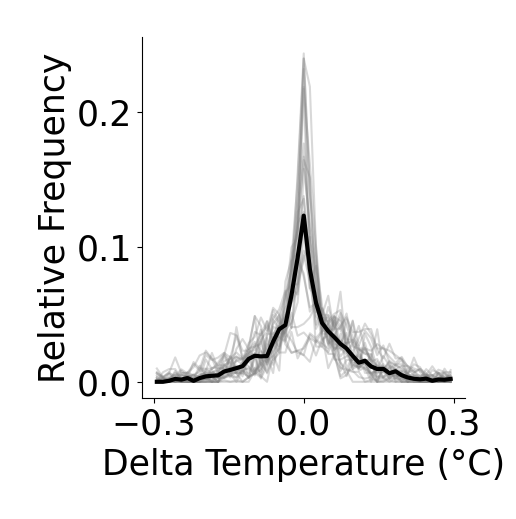

In [33]:
bins_plot = (bins_[:-1]+bins_[1:])/2
plt.figure()
for i in range(delta_distributions.shape[0]):
    plt.plot(bins_plot,delta_distributions[i,:],c="gray",lw=1.5,alpha=.3)
plt.plot(bins_plot,np.nanmedian(delta_distributions,0),c="k",lw=3)
plt.yticks([0,.1,.2],fontsize=25)
plt.xticks([-.3,0,.3],fontsize=25)
plt.ylabel("Relative Frequency",fontsize=25)
plt.xlabel("Delta Temperature (°C)",fontsize=25)
sns.despine()
set_size(4,4)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\new_supp_3_e.png",dpi=800)

In [577]:
turn_th = np.deg2rad(30)
iso_th = 0.1333
delta_bins = np.linspace(0.1333,0,4)[:-1]
results_all_fish = []
# pool_fish = pd.concat(WT)
for pool_fish in WT:
    distant = pool_fish["temp_start"].values >1
    temp_past = pool_fish["prev_temp"].values-pool_fish["delta_1"].values
    delta_past = pool_fish["prev_temp"].values - temp_past
    past_wctx = pool_fish.iloc[(distant)&(delta_past<-iso_th)]
    past_ictx = pool_fish.iloc[(distant)&(delta_past>iso_th)]
    results = np.zeros(delta_bins.shape[0])
    for id_ in range(delta_bins.shape[0]):
        ft_wctx = np.sum(abs(past_wctx.iloc[abs(past_wctx["delta"].values)<delta_bins[id_]]["theta_bout"].values)>np.deg2rad(turn_th))/np.sum(abs(past_wctx["delta"].values)<delta_bins[id_])
        ft_ictx = np.sum(abs(past_ictx.iloc[abs(past_ictx["delta"].values)<delta_bins[id_]]["theta_bout"].values)>np.deg2rad(turn_th))/np.sum(abs(past_ictx["delta"].values)<delta_bins[id_])

        results[id_] = ft_wctx - ft_ictx
    results_all_fish.append(results)

C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


In [578]:
turn_th = np.deg2rad(30)
th_min_bouts = 5
n_thresholds = 10

delta_bins = np.array([-10,-iso_th,iso_th,10])
list_thresholds = list(np.linspace(0.1333,0.07,n_thresholds))


n_iters = 100
pool_thresholdsrand_final = []
for _ in range(n_iters):
    pool_thresholdsrand = []
    delta_bins = np.array([-10,-iso_th,iso_th,10])
    for iso_th in list_thresholds:
        turn_index = []
        for fish_ in WT:
            distant = fish_["temp_start"].values >1
            fish_ = fish_.iloc[(fish_["delta"].values>-iso_th)&(fish_["delta"].values<iso_th)&distant]
            fish_vect = []
            for s_,e_ in zip(delta_bins[:-1],delta_bins[1:]):
                delta_1_shuffle = fish_["delta_1"].values.copy()
                np.random.shuffle(delta_1_shuffle)
                temp_past = fish_["prev_temp"].values-delta_1_shuffle
                delta_past = fish_["prev_temp"].values - temp_past
                bouts_in_bin = fish_.iloc[(delta_past>=s_)&(delta_past<e_)]
                if len(bouts_in_bin) > th_min_bouts:
                    fract_turns = [(abs(bouts_in_bin["theta_bout"].values)>turn_th).sum()/len(bouts_in_bin)]
                else:
                    fract_turns = [np.nan]
                fish_vect.append(fract_turns)
            turn_index.append(fish_vect-np.array(fish_vect[-1]))
        pool_thresholdsrand.append(np.array(turn_index)[:,0,0])
    pool_thresholdsrand_final.append(np.nanmedian(np.stack(pool_thresholdsrand,0),1))
pool_thresholdsrand_final = np.stack(pool_thresholdsrand_final,0)

turn_th = np.deg2rad(30)
th_min_bouts = 5
iso_th = 0.1333
delta_bins = np.array([-10,-iso_th,iso_th,10])
turn_index = []
for fish_ in WT:
    #is_in = fish_["out"].values == False
    distant = fish_["temp_start"].values >1
    fish_ = fish_.iloc[(fish_["delta"].values>-iso_th)&(fish_["delta"].values<iso_th)&distant]
    fish_vect = []
    for s_,e_ in zip(delta_bins[:-1],delta_bins[1:]):
        temp_past = fish_["prev_temp"].values-fish_["delta_1"].values
        delta_past = fish_["prev_temp"].values - temp_past
        #delta_past = fish_["delta_1"].values
        bouts_in_bin = fish_.iloc[(delta_past>=s_)&(delta_past<e_)]
                                  #&(fish_["delta"].values>fish_["delta_1"].values)]
        if len(bouts_in_bin) > th_min_bouts:
            fract_turns = [(abs(bouts_in_bin["theta_bout"].values)>turn_th).sum()/len(bouts_in_bin)]
            #fract_turns = [np.nanmedian(abs(bouts_in_bin["theta_bout"].values))]
        else:
            fract_turns = [np.nan]
        fish_vect.append(fract_turns)
    turn_index.append(fish_vect-np.array(fish_vect[-1]))
turn_index = np.array(turn_index)

pool_thresholds = []
for iso_th in list_thresholds:
    turn_index = []
    for fish_ in WT:
        distant = fish_["temp_start"].values >1
        fish_ = fish_.iloc[(fish_["delta"].values>-iso_th)&(fish_["delta"].values<iso_th)&distant]
        fish_vect = []
        for s_,e_ in zip(delta_bins[:-1],delta_bins[1:]):
            temp_past = fish_["prev_temp"].values-fish_["delta_1"].values
            delta_past = fish_["prev_temp"].values - temp_past
            bouts_in_bin = fish_.iloc[(delta_past>=s_)&(delta_past<e_)]
            if len(bouts_in_bin) > th_min_bouts:
                fract_turns = [(abs(bouts_in_bin["theta_bout"].values)>turn_th).sum()/len(bouts_in_bin)]
            else:
                fract_turns = [np.nan]
            fish_vect.append(fract_turns)
        turn_index.append(fish_vect-np.array(fish_vect[-1]))
    pool_thresholds.append(np.array(turn_index)[:,0,0])
pool_thresholds = np.stack(pool_thresholds,0)

C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in greater_equal
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in less
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in less
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater_equal
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in less
C:\Users\epaoli\

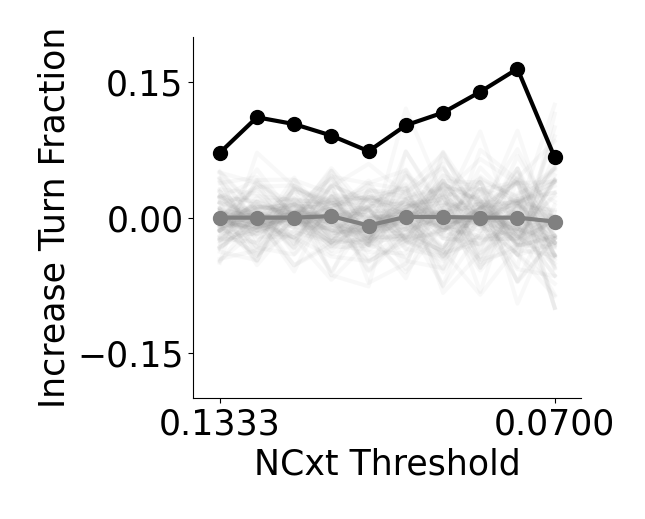

In [579]:
plt.figure()
plt.plot(list_thresholds,pool_thresholdsrand_final.T,c="gray",alpha=.05,lw=3,ms=10)
plt.plot(list_thresholds,np.nanmedian(pool_thresholdsrand_final,0),"-o",c="gray",alpha=1,lw=3,ms=10)
plt.plot(list_thresholds,np.nanmedian(pool_thresholds,1),"-ok",lw=3,ms=10)
plt.ylabel("Increase Turn Fraction",fontsize=25)
plt.xticks([list_thresholds[0],list_thresholds[-1]],fontsize=25)
plt.xlabel("NCxt Threshold",fontsize=25)
plt.ylim([-.2,.2])
plt.yticks([-.15,0,.15],fontsize=25)
plt.xlim([list_thresholds[0]+.005,list_thresholds[-1]-.005])
sns.despine()
set_size(5,4)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\supp_2_d.png",dpi=800)

### motor memory

In [118]:
from scipy.stats import wilcoxon

In [119]:
th_min_bouts = 0
iso_th = 0.1333
th_ = 30
n_reps = 100
turn_th = np.deg2rad(30)


In [122]:

ipsi_index_WT = []
ipsi_index_WT_random = []

for fish_ in WT:
    distant = fish_["temp_start"].values >1
    temp_past = fish_["prev_temp"].values-fish_["delta_1"].values
    delta_past = fish_["prev_temp"].values - temp_past
    where_turn = abs(fish_["prev_bias"].values) >= turn_th
    fish_ = fish_.iloc[(fish_["delta"].values<-iso_th)&distant]
    if len(fish_) > th_min_bouts:

        num_ipsi = fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(fish_["prev_bias"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)])
        ipsi_index_WT.append(np.nanmean(num_ipsi))
        rand_res = []
        for _ in range(n_reps):
            prev_theta = random.choices(np.array([-1,1]),np.array([.5,.5]),k=np.sum(abs(fish_["prev_bias"])>np.deg2rad(th_)))
            rand_res.append(np.nanmean(fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(prev_theta)))
        ipsi_index_WT_random.append(np.nanmean(rand_res,0))
        
ipsi_index_WT = np.array(ipsi_index_WT)
ipsi_index_WT_random = np.array(ipsi_index_WT_random)


ipsi_index_Hbneg_post = []
ipsi_index_Hbneg_post_random = []

for fish_ in Hbneg_post:
    distant = fish_["temp_start"].values >1
    temp_past = fish_["prev_temp"].values-fish_["delta_1"].values
    delta_past = fish_["prev_temp"].values - temp_past
    where_turn = abs(fish_["prev_bias"].values) >= turn_th
    fish_ = fish_.iloc[(fish_["delta"].values<-iso_th)&distant]
    if len(fish_) > th_min_bouts:

        num_ipsi = fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(fish_["prev_bias"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)])
        ipsi_index_Hbneg_post.append(np.nanmean(num_ipsi))
        rand_res = []
        for _ in range(n_reps):
            prev_theta = random.choices(np.array([-1,1]),np.array([.5,.5]),k=np.sum(abs(fish_["prev_bias"])>np.deg2rad(th_)))
            rand_res.append(np.nanmean(fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(prev_theta)))
        ipsi_index_Hbneg_post_random.append(np.nanmean(rand_res,0))
ipsi_index_Hbneg_post = np.array(ipsi_index_Hbneg_post)
ipsi_index_Hbneg_post_random = np.array(ipsi_index_Hbneg_post_random)


ipsi_index_Hbpos_pre = []
ipsi_index_Hbpos_pre_random = []

for fish_ in Hbpos_pre:
    distant = fish_["temp_start"].values >1
    temp_past = fish_["prev_temp"].values-fish_["delta_1"].values
    delta_past = fish_["prev_temp"].values - temp_past
    where_turn = abs(fish_["prev_bias"].values) >= turn_th
    fish_ = fish_.iloc[(fish_["delta"].values<-iso_th)&distant]
    if len(fish_) > th_min_bouts:

        num_ipsi = fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(fish_["prev_bias"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)])
        ipsi_index_Hbpos_pre.append(np.nanmean(num_ipsi))
        rand_res = []
        for _ in range(n_reps):
            prev_theta = random.choices(np.array([-1,1]),np.array([.5,.5]),k=np.sum(abs(fish_["prev_bias"])>np.deg2rad(th_)))
            rand_res.append(np.nanmean(fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(prev_theta)))
        ipsi_index_Hbpos_pre_random.append(np.nanmean(rand_res,0))
ipsi_index_Hbpos_pre = np.array(ipsi_index_Hbpos_pre)
ipsi_index_Hbpos_pre_random = np.array(ipsi_index_Hbpos_pre_random)

ipsi_index_Hbpos_post = []
ipsi_index_Hbpos_post_random = []
for fish_ in Hbpos_post:
    distant = fish_["temp_start"].values >1
    temp_past = fish_["prev_temp"].values-fish_["delta_1"].values
    delta_past = fish_["prev_temp"].values - temp_past
    where_turn = abs(fish_["prev_bias"].values) >= turn_th
    fish_ = fish_.iloc[(fish_["delta"].values<-iso_th)&distant]
    if len(fish_) > th_min_bouts:

        num_ipsi = fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(fish_["prev_bias"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)])
        ipsi_index_Hbpos_post.append(np.nanmean(num_ipsi))
        rand_res = []
        for _ in range(n_reps):
            prev_theta = random.choices(np.array([-1,1]),np.array([.5,.5]),k=np.sum(abs(fish_["prev_bias"])>np.deg2rad(th_)))
            rand_res.append(np.nanmean(fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(prev_theta)))
        ipsi_index_Hbpos_post_random.append(np.nanmean(rand_res,0))
ipsi_index_Hbpos_post = np.array(ipsi_index_Hbpos_post)
ipsi_index_Hbpos_post_random = np.array(ipsi_index_Hbpos_post_random)


C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: Mean of empty slice
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: Mean of empty slice


In [120]:
ipsi_index_ot_abl = []
ipsi_index_ot_abl_random = []

for fish_ in ot_abl:
    distant = fish_["temp_start"].values >1
    temp_past = fish_["prev_temp"].values-fish_["delta_1"].values
    delta_past = fish_["prev_temp"].values - temp_past
    where_turn = abs(fish_["prev_bias"].values) >= turn_th
    fish_ = fish_.iloc[(fish_["delta"].values<-iso_th)&distant]
    if len(fish_) > th_min_bouts:

        num_ipsi = fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(fish_["prev_bias"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)])
        ipsi_index_ot_abl.append(np.nanmean(num_ipsi))
        rand_res = []
        for _ in range(n_reps):
            prev_theta = random.choices(np.array([-1,1]),np.array([.5,.5]),k=np.sum(abs(fish_["prev_bias"])>np.deg2rad(th_)))
            rand_res.append(np.nanmean(fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(prev_theta)))
        ipsi_index_ot_abl_random.append(np.nanmean(rand_res,0))
ipsi_index_ot_abl = np.array(ipsi_index_ot_abl)
ipsi_index_ot_abl_random = np.array(ipsi_index_ot_abl_random)

ipsi_index_poa_abl = []
ipsi_index_poa_abl_random = []
for fish_ in poa_abl:
    distant = fish_["temp_start"].values >1
    temp_past = fish_["prev_temp"].values-fish_["delta_1"].values
    delta_past = fish_["prev_temp"].values - temp_past
    where_turn = abs(fish_["prev_bias"].values) >= turn_th
    fish_ = fish_.iloc[(fish_["delta"].values<-iso_th)&distant]
    if len(fish_) > th_min_bouts:

        num_ipsi = fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(fish_["prev_bias"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)])
        ipsi_index_poa_abl.append(np.nanmean(num_ipsi))
        rand_res = []
        for _ in range(n_reps):
            prev_theta = random.choices(np.array([-1,1]),np.array([.5,.5]),k=np.sum(abs(fish_["prev_bias"])>np.deg2rad(th_)))
            rand_res.append(np.nanmean(fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(prev_theta)))
        ipsi_index_poa_abl_random.append(np.nanmean(rand_res,0))
ipsi_index_poa_abl = np.array(ipsi_index_poa_abl)
ipsi_index_poa_abl_random = np.array(ipsi_index_poa_abl_random)


C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: Mean of empty slice
C:\Users\ge59xan\miniconda3\envs\rplab\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice


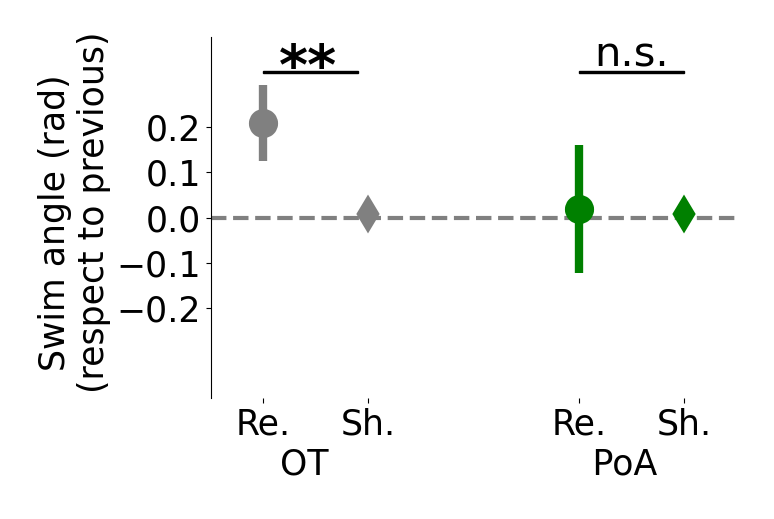

In [49]:
plt.figure()

plt.plot([-3.5,4.5],[0,0],"--",c="gray",lw=3)

to_plot = ipsi_index_ot_abl.copy()
plt.errorbar([-3],y=np.array([np.nanmean(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=14,marker="o",mew=7,c="gray",
            capthick=5)

to_plot = ipsi_index_ot_abl_random.copy()
plt.errorbar([-2],y=np.array([np.nanmean(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=10,marker="d",mew=7,c="gray",
            capthick=5)

to_plot = ipsi_index_poa_abl.copy()
plt.errorbar([0],y=np.array([np.nanmean(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=14,marker="o",mew=7,c="green",
            capthick=5)

to_plot = ipsi_index_poa_abl_random.copy()
plt.errorbar([1],y=np.array([np.nanmean(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=10,marker="d",mew=7,c="green",
            capthick=5)

plt.axvspan(-3,-2.1,.9,.905,color="k")
plt.text(-2.85,0.295,"**",color="k",fontsize=40,fontweight="bold")

plt.axvspan(0,1,.9,.905,color="k")
plt.text(0.15,0.335,"n.s.",color="k",fontsize=30)

plt.xlim([-3.5,1.5])
plt.ylim([-0.4,.4])
plt.yticks([-.2,-.1,0,.1,.2],fontsize=25)
plt.xlabel("OT                        PoA ",fontsize=25)
plt.xticks([-3,-2,0, 1],["Re.","Sh."]*2,fontsize=25)
plt.ylabel("Swim angle (rad) \n (respect to previous)",fontsize=25)
sns.despine(bottom=True)
set_size(6,4)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\new_figs_new\5_c_new.png",dpi=800)

In [16]:
ipsi_index_poa_abl

array([        nan,  1.1559835 ,  0.08080491, -0.28273793,  0.05993914,
               nan,  0.11676763, -1.89729735,  0.02573448,  0.44678065,
       -0.03343837, -0.0719872 ,  0.09857214,  0.124483  ,  0.0840739 ,
        0.10784232, -0.17773423,  0.1660913 ,  0.33236969])

In [17]:
print(mannwhitneyu(ipsi_index_ot_abl,ipsi_index_ot_abl_random)[1],
mannwhitneyu(ipsi_index_poa_abl[np.isfinite(ipsi_index_poa_abl)],
             ipsi_index_poa_abl_random[np.isfinite(ipsi_index_poa_abl)])[1])

0.007113494035772574 0.08503753250299094


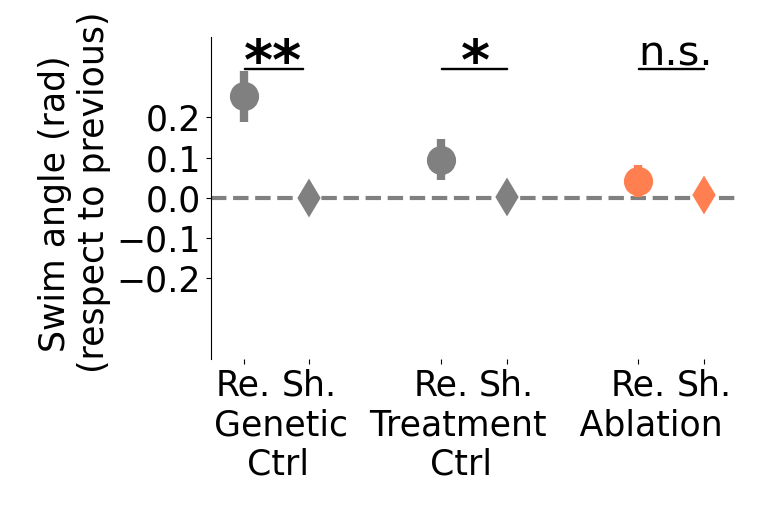

In [124]:
plt.figure()

plt.plot([-3.5,4.5],[0,0],"--",c="gray",lw=3)

to_plot = ipsi_index_Hbpos_pre.copy()
plt.errorbar([-3],y=np.array([np.nanmean(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=14,marker="o",mew=7,c="gray",
            capthick=5)

to_plot = ipsi_index_Hbpos_pre_random.copy()
plt.errorbar([-2],y=np.array([np.nanmean(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=10,marker="d",mew=7,c="gray",
            capthick=5)

to_plot = ipsi_index_Hbneg_post.copy()
plt.errorbar([0],y=np.array([np.nanmean(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=14,marker="o",mew=7,c="gray",
            capthick=5)

to_plot = ipsi_index_Hbneg_post_random.copy()
plt.errorbar([1],y=np.array([np.nanmean(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=10,marker="d",mew=7,c="gray",
            capthick=5)

to_plot = ipsi_index_Hbpos_post.copy()
abl = to_plot.copy()
plt.errorbar([3],y=np.array([np.nanmean(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=14,marker="o",mew=7,c="coral",
            capthick=5)

to_plot = ipsi_index_Hbpos_post_random.copy()
plt.errorbar([4],y=np.array([np.nanmean(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=10,marker="d",mew=7,c="coral",
            capthick=5)

plt.axvspan(-3,-2.1,.9,.905,color="k")
plt.text(-3,0.295,"**",color="k",fontsize=40,fontweight="bold")

plt.axvspan(0,1,.9,.905,color="k")
plt.text(0.3,0.295,"*",color="k",fontsize=40,fontweight="bold")

plt.axvspan(3,4,.9,.905,color="k")
plt.text(3,0.33,"n.s.",color="k",fontsize=30)

plt.xlim([-3.5,4.5])
plt.ylim([-0.4,.4])
plt.yticks([-.2,-.1,0,.1,.2],fontsize=25)
plt.xlabel("Genetic  Treatment   Ablation \n Ctrl           Ctrl                    ",fontsize=25)
plt.xticks([-3,-2,0, 1,3,4],["Re.","Sh."]*3,fontsize=25)
plt.ylabel("Swim angle (rad) \n (respect to previous)",fontsize=25)
sns.despine(bottom=True)
set_size(6,4)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\ge59xan\Desktop\final_svgs\5_c.png",dpi=800)

In [541]:
print(mannwhitneyu(ipsi_index_Hbpos_pre,ipsi_index_Hbpos_pre_random)[1],
mannwhitneyu(ipsi_index_Hbneg_post,ipsi_index_Hbneg_post_random)[1],
mannwhitneyu(ipsi_index_Hbpos_post,ipsi_index_Hbpos_post_random)[1],)

0.0014038690748747731 0.027981818180052607 0.3147429271583916


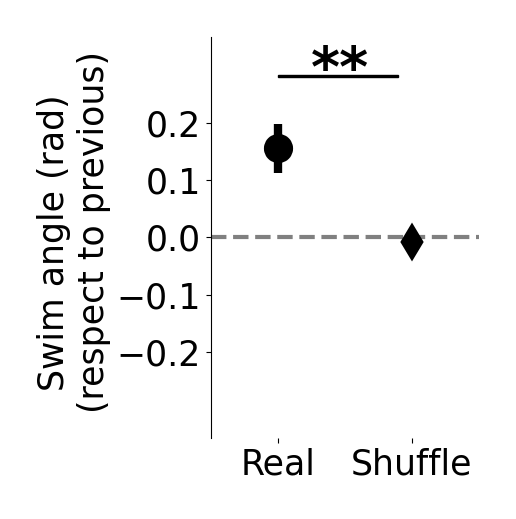

In [586]:
plt.figure(figsize=(3,5))
plt.plot([-3.5,-1.5],[0,0],"--",c="gray",lw=3)
to_plot = ipsi_index_WT.copy()
plt.errorbar([-3],y=np.array([np.nanmean(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=14,marker="o",mew=7,c="k",
            capthick=5)

to_plot = ipsi_index_WT_random.copy()
plt.errorbar([-2],y=np.array([np.nanmean(to_plot)]),
            yerr=sem(to_plot,nan_policy="omit"),
            lw=6,fmt="-",ms=10,marker="d",mew=7,c="k",
            capthick=5)

plt.axvspan(-3,-2.1,.9,.905,color="k")
plt.text(-2.75,0.265,"**",color="k",fontsize=40,fontweight="bold")

plt.xlim([-3.5,-1.5])
plt.ylim([-0.35,.35])
plt.yticks([-.2,-.1,0,.1,.2],fontsize=25)
plt.xticks([-3,-2],["Real","Shuffle"],fontsize=25)
plt.ylabel("Swim angle (rad) \n (respect to previous)",fontsize=25)
sns.despine(bottom=True)
set_size(4,4)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\2_c.png",dpi=800)

In [563]:
print(mannwhitneyu(ipsi_index_WT,ipsi_index_WT_random)[1])

0.0019199400006775233


In [565]:
ipsi_index_Hbpos_post_pool = []
for fish_ in Hbpos_post:
    distant = fish_["temp_start"].values >1
    temp_past = fish_["prev_temp"].values-fish_["delta_1"].values
    delta_past = fish_["prev_temp"].values - temp_past
    where_turn = (abs(fish_["prev_bias"].values) >= turn_th)
    fish_ = fish_.iloc[(fish_["delta"].values<-iso_th)&distant]
    if len(fish_) > th_min_bouts:

        num_ipsi = fish_["theta_bout"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)]*np.sign(fish_["prev_bias"].values[abs(fish_["prev_bias"])>np.deg2rad(th_)])
        ipsi_index_Hbpos_post_pool.extend(num_ipsi)
ipsi_index_Hbpos_post_pool = np.array(ipsi_index_Hbpos_post_pool)


C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater_equal
  
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in less
  import sys


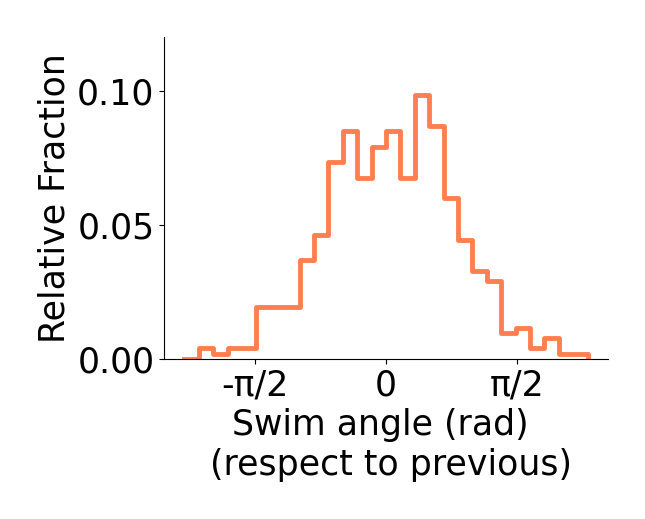

In [569]:
plt.figure()
bins_ = np.linspace(-2.5,2.5,30)
bins_plot =- (bins_[:-1]+bins_[1:])/2
c,_ = np.histogram(ipsi_index_Hbpos_post_pool, bins_)
c = c / np.sum(c)
plt.step(bins_plot,c, lw=3.5,c="coral")
plt.ylim([0,.12])
plt.yticks([0,.05,.1],fontsize=25)
plt.xticks([-np.pi/2,0, np.pi/2],["-π/2","0","π/2"], fontsize=25)
plt.ylabel("Relative Fraction", fontsize=25)
plt.xlabel("Swim angle (rad) \n (respect to previous)",fontsize=25)
sns.despine()
set_size(5,4)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\epaoli\Desktop\new_figs\supp_6_h.png",dpi=800)

In [656]:
context_colors = ["#036860","#8e530b"]

In [523]:
bins = np.linspace(0,6.375,4)
th_ = 2.5
data_Hbneg_post = []
for fish_ in Hbneg_post:
    counts,_ = np.histogram(fish_["temp_start"].values,bins)
    rel_freq = counts / np.nansum(counts)
    data_Hbneg_post.append(np.nanstd(fish_["temp_start"].values[fish_["t_start"].values>600]))

data_Hbpos_pre = []    
for fish_ in Hbpos_pre:
    counts,_ = np.histogram(fish_["temp_start"].values,bins)
    rel_freq = counts / np.nansum(counts)
    data_Hbpos_pre.append(np.nanstd(fish_["temp_start"].values[fish_["t_start"].values>600]))

data_Hbpos_post = []
for fish_ in Hbpos_post:
    counts,_ = np.histogram(fish_["temp_start"].values,bins)
    rel_freq = counts / np.nansum(counts)
    data_Hbpos_post.append(np.nanstd(fish_["temp_start"].values[fish_["t_start"].values>600]))
    
data_ot_abl = []   
for fish_ in ot_abl:
    counts,_ = np.histogram(fish_["temp_start"],bins)
    rel_freq = counts / np.nansum(counts)
    data_ot_abl.append(np.nanstd(fish_["temp_start"].values[fish_["t_start"].values>600]))
    
data_poa_abl = []     
for fish_ in poa_abl:
    counts,_ = np.histogram(fish_["temp_start"],bins)
    rel_freq = counts / np.nansum(counts)
    data_poa_abl.append(np.nanstd(fish_["temp_start"].values[fish_["t_start"].values>600]))
    
# data_wt = []    
# for fish_ in Hbneg_post:
#     counts,_ = np.histogram(fish_["temp_start"],bins)
#     rel_freq = counts / np.sum(counts)
#     data_Hbneg_post.append(rel_freq)
b = (bins[:-1]+bins[1:])/2

C:\Users\epaoli\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  from ipykernel import kernelapp as app
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.


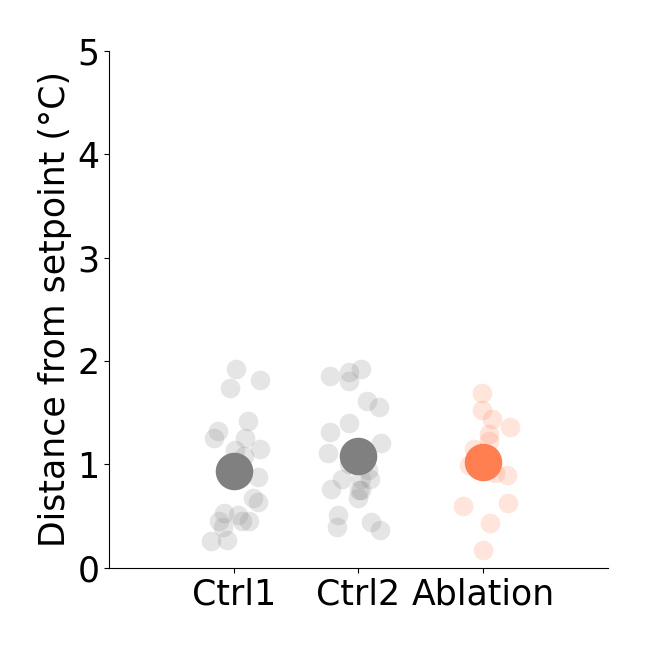

In [524]:
plt.figure()

x_points = np.random.uniform(low=-.25,high=.25,size=(len(data_Hbneg_post)))
plt.scatter(x_points,data_Hbneg_post,s=200,alpha=.2,c="gray",linewidths=0)
plt.errorbar([0],np.nanmean(data_Hbneg_post,0),
             yerr=sem(data_Hbneg_post,0,nan_policy="omit"),
            lw=6,fmt="o",ms=20,marker="o",mew=7,c="gray",
            capthick=5)

x_points = np.random.uniform(low=1-.25,high=1.25,size=(len(data_Hbpos_pre)))
plt.scatter(x_points,data_Hbpos_pre,s=200,alpha=.2,c="gray",linewidths=0)
plt.errorbar([1],np.nanmean(data_Hbpos_pre,0),
             yerr=sem(data_Hbpos_pre,0,nan_policy="omit"),
            lw=6,fmt="o",ms=20,marker="o",mew=7,c="gray",
            capthick=5)

x_points = np.random.uniform(low=2-.25,high=2.25,size=(len(data_Hbpos_post)))
plt.scatter(x_points,data_Hbpos_post,s=200,alpha=.2,c="coral",linewidths=0)
plt.errorbar([2],np.nanmean(np.array(data_Hbpos_post),0),
             yerr=sem(np.array(data_Hbpos_post),0,nan_policy="omit"),
            lw=6,fmt="o",ms=20,marker="o",mew=7,c="coral",
            capthick=5)

# plt.axvspan(0,1,.9,.905,color="k")
# plt.text(0.4,4.4,"*",color="k",fontsize=40,fontweight="bold")

plt.ylabel("Distance from setpoint (°C)",fontsize=25)
plt.xticks([0,1,2],["Ctrl1","Ctrl2","Ablation"],fontsize=25)
plt.yticks([0,1,2,3,4,5],fontsize=25)
plt.ylim([0,5])
plt.xlim(-1,3)
set_size(5,5)
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig(r"C:\Users\epaoli\Desktop\new_figs_new\supp_5_e_new.png",dpi=800)
# plt.savefig(r"C:\Users\epaoli\Desktop\new_figs_new\supp_5_e_new.pdf",dpi=800)

In [514]:
print(mannwhitneyu(np.stack(data_Hbneg_post),np.stack(data_Hbpos_post))[1])
print(mannwhitneyu(np.stack(data_Hbpos_pre),np.stack(data_Hbpos_post))[1])

0.25037786433152864
0.12375028982115427


C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  
C:\Users\epaoli\anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  from ipykernel import kernelapp as app


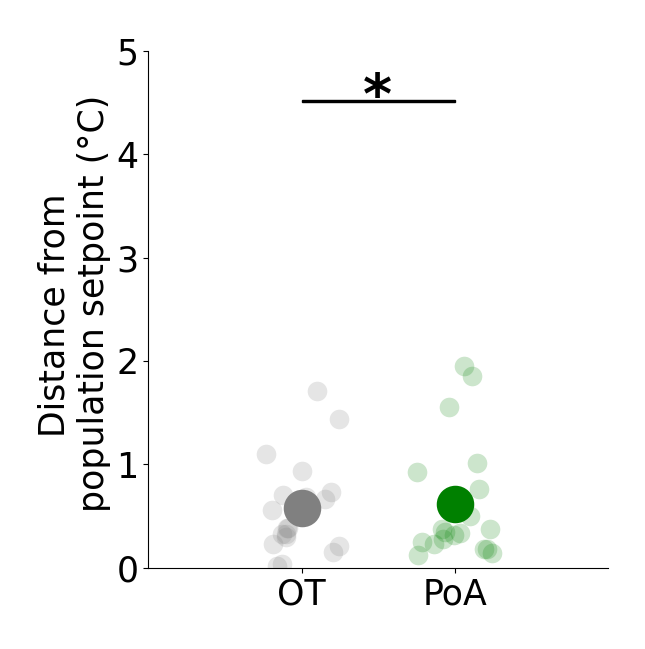

In [525]:
plt.figure()

x_points = np.random.uniform(low=-.25,high=.25,size=(len(data_ot_abl)))
plt.scatter(x_points,data_ot_abl,s=200,alpha=.2,c="gray",linewidths=0)
plt.errorbar([0],np.nanmean(data_ot_abl,0),
             yerr=sem(data_ot_abl,0,nan_policy="omit"),
            lw=6,fmt="o",ms=20,marker="o",mew=7,c="gray",
            capthick=5)

x_points = np.random.uniform(low=1-.25,high=1.25,size=(len(data_poa_abl)))
plt.scatter(x_points,data_poa_abl,s=200,alpha=.2,c="green",linewidths=0)
plt.errorbar([1],np.nanmean(np.array(data_poa_abl),0),
             yerr=sem(np.array(data_poa_abl),0,nan_policy="omit"),
            lw=6,fmt="o",ms=20,marker="o",mew=7,c="green",
            capthick=5)

plt.axvspan(0,1,.9,.905,color="k")
plt.text(0.4,4.4,"*",color="k",fontsize=40,fontweight="bold")

plt.ylabel("Distance from \n population setpoint (°C)",fontsize=25)
plt.xticks([0,1],["OT","PoA"],fontsize=25)
plt.yticks([0,1,2,3,4,5],fontsize=25)
plt.ylim([0,5])
plt.xlim(-1,2)
set_size(5,5)
sns.despine()
plt.tight_layout()
plt.show()
# plt.savefig(r"C:\Users\epaoli\Desktop\new_figs_new\5_b_new.png",dpi=800)
# plt.savefig(r"C:\Users\epaoli\Desktop\new_figs_new\5_b_new.pdf",dpi=800)

In [519]:
print(mannwhitneyu(np.stack(data_ot_abl),np.stack(data_poa_abl))[1])

0.19708545497582258
